# ***Start***


In [ ]:
!pip install transformers

In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time
import numpy as np
import pandas as pd
import json
import math
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Save model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ***Step 1:*** Download CoQA dataset and Tranformers library

In [ ]:
%%capture
!git clone https://github.com/Ele975/AML_project2.git
!pip -q install datasets

In [ ]:
%%capture
from transformers import AutoTokenizer,BertTokenizerFast
from urllib.request import urlopen
import datasets


## ***Step 2:*** Retrieve and Store the data

In [ ]:
train = pd.read_json("http://curtis.ml.cmu.edu/datasets/hotpot/hotpot_train_v1.1.json")
val = pd.read_json("http://curtis.ml.cmu.edu/datasets/hotpot/hotpot_dev_fullwiki_v1.json")
#test =

In [ ]:
train.head()

,supporting_facts,level,question,context,answer,_id,type
0,"[[Arthur's Magazine, 0], [First for Women, 0]]",medium,Which magazine was started first Arthur's Maga...,"[[Radio City (Indian radio station), [Radio Ci...",Arthur's Magazine,5a7a06935542990198eaf050,comparison
1,"[[Oberoi family, 0], [The Oberoi Group, 0]]",medium,The Oberoi family is part of a hotel company t...,"[[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...",Delhi,5a879ab05542996e4f30887e,bridge
2,"[[Allie Goertz, 0], [Allie Goertz, 1], [Allie ...",hard,Musician and satirist Allie Goertz wrote a son...,"[[Lisa Simpson, [Lisa Marie Simpson is a ficti...",President Richard Nixon,5a8d7341554299441c6b9fe5,bridge
3,"[[Peggy Seeger, 0], [Peggy Seeger, 1], [Ewan M...",medium,What nationality was James Henry Miller's wife?,"[[Moloch: or, This Gentile World, [Moloch: or,...",American,5a82171f5542990a1d231f4a,bridge
4,"[[Cadmium chloride, 1], [Ethanol, 0]]",medium,Cadmium Chloride is slightly soluble in this c...,"[[Cadmium chloride, [Cadmium chloride is a whi...",alcohol,5a84dd955542997b5ce3ff79,bridge


In [ ]:
import string

##cleaning up the context of the dataset
newDF = train[['question','answer', 'context', 'supporting_facts']]
newDF = newDF.dropna()
newDF['context'] = newDF['context'].astype(str).str.replace(r'\\n', ' ')
newDF['context'] = newDF['context'].str.replace('['.format(string.punctuation), '')
newDF['context'] = newDF['context'].str.replace(']'.format(string.punctuation), '')
newDF['context'] = newDF['context'].str.replace('\\'.format(string.punctuation), '')
newDF['context'] = newDF['context'].str.replace("'".format(string.punctuation), '')
newDF['context'] = newDF['context'].str.replace("[^\w\s/-]".format(string.punctuation), '')


##cleaning the suporting fact
newDF['supporting_facts'] = newDF['supporting_facts'].astype(str).str.replace(r'\\n', ' ')
newDF['supporting_facts'] = newDF['supporting_facts'].str.replace('['.format(string.punctuation), '')
newDF['supporting_facts'] = newDF['supporting_facts'].str.replace(']'.format(string.punctuation), '')
newDF['supporting_facts'] = newDF['supporting_facts'].str.replace('\\'.format(string.punctuation), '')
newDF['supporting_facts'] = newDF['supporting_facts'].str.replace("'".format(string.punctuation), '')
newDF['supporting_facts'] = newDF['supporting_facts'].str.replace("[^\w\s/\d+-]".format(string.punctuation), '')
newDF['supporting_facts'] = newDF['supporting_facts'].str.replace("[\d+]".format(string.punctuation), '') #remove digits

<ipython-input-8-93991aa71230>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  newDF['context'] = newDF['context'].astype(str).str.replace(r'\\n', ' ')
<ipython-input-8-93991aa71230>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  newDF['context'] = newDF['context'].str.replace('['.format(string.punctuation), '')
<ipython-input-8-93991aa71230>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  newDF['context'] = newDF['context'].str.replace(']'.format(string.punctuation), '')
<ipython-input-8-93991aa71230>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single chara

In [ ]:
newDF.head()

,question,answer,context,supporting_facts
0,Which magazine was started first Arthur's Maga...,Arthur's Magazine,Radio City Indian radio station Radio City is ...,Arthurs Magazine First for Women
1,The Oberoi family is part of a hotel company t...,Delhi,Ritz-Carlton Jakarta The Ritz-Carlton Jakarta ...,Oberoi family The Oberoi Group
2,Musician and satirist Allie Goertz wrote a son...,President Richard Nixon,Lisa Simpson Lisa Marie Simpson is a fictional...,Allie Goertz Allie Goertz Allie Goertz Milh...
3,What nationality was James Henry Miller's wife?,American,Moloch or This Gentile World Moloch or This Ge...,Peggy Seeger Peggy Seeger Ewan MacColl
4,Cadmium Chloride is slightly soluble in this c...,alcohol,Cadmium chloride Cadmium chloride is a white c...,Cadmium chloride Ethanol


In [ ]:
newDF["context"][1]

'Ritz-Carlton Jakarta The Ritz-Carlton Jakarta is a hotel and skyscraper in Jakarta Indonesia and 14th Tallest building in Jakarta  It is located in city center of Jakarta near Mega Kuningan adjacent to the sister JW Marriott Hotel  It is operated by The Ritz-Carlton Hotel Company  The complex has two towers that comprises a hotel and the Airlangga Apartment respectively  The hotel was opened in 2005 Oberoi family The Oberoi family is an Indian family that is famous for its involvement in hotels namely through The Oberoi Group Ishqbaaaz Ishqbaaaz English Lovers is an Indian drama television series which is broadcast on Star Plus  It premiered on 27 June 2016 and airs Mon-Fri 10-11pm IST Nakuul Mehta Kunal Jaisingh and Leenesh Mattoo respectively portray Shivaay Omkara and Rudra the three heirs of the Oberoi family  The show initially focused on the tale of three brothers later become centered on the love story of Shivaay and Annika Surbhi Chandna with the story of Omkara and Rudra bein

In [ ]:
# def process_row():
#   newDF['context'] = newDF['context'].astype(str).str.replace(r'\\n', ' ')
#   newDF['context'] = newDF['context'].str.replace('['.format(string.punctuation), '')
#   newDF['context'] = newDF['context'].str.replace(']'.format(string.punctuation), '')
#   newDF['context'] = newDF['context'].str.replace('\\'.format(string.punctuation), '')
#   newDF['context'] = newDF['context'].str.replace("'".format(string.punctuation), '')
#   newDF['context'] = newDF['context'].str.replace("[^\w\s/-]".format(string.punctuation), '')
#   return newDF

# # Apply the function to each element in 'Column1'
# train = train[['question','answer', 'context']]
# newDF = newDF.dropna()
# trainData = train.apply(process_row)


In [ ]:
##cleaning up the context of the dataset
valData = val[['question','answer', 'context', 'supporting_facts']]
valData = valData.dropna()
valData['context'] = valData['context'].astype(str).str.replace(r'\\n', ' ')
valData['context'] = valData['context'].str.replace('['.format(string.punctuation), '')
valData['context'] = valData['context'].str.replace(']'.format(string.punctuation), '')
valData['context'] = valData['context'].str.replace('\\'.format(string.punctuation), '')
valData['context'] = valData['context'].str.replace("'".format(string.punctuation), '')
valData['context'] = valData['context'].str.replace("[^\w\s/-]".format(string.punctuation), '')


valData['supporting_facts'] = valData['supporting_facts'].astype(str).str.replace(r'\\n', ' ')
valData['supporting_facts'] = valData['supporting_facts'].str.replace('['.format(string.punctuation), '')
valData['supporting_facts'] = valData['supporting_facts'].str.replace(']'.format(string.punctuation), '')
valData['supporting_facts'] = valData['supporting_facts'].str.replace('\\'.format(string.punctuation), '')
valData['supporting_facts'] = valData['supporting_facts'].str.replace("'".format(string.punctuation), '')
valData['supporting_facts'] = valData['supporting_facts'].str.replace("[^\w\s/\d+-]".format(string.punctuation), '')
valData['supporting_facts'] = valData['supporting_facts'].str.replace("[\d+]".format(string.punctuation), '') #remove digits

<ipython-input-12-ae9888ff64ca>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  valData['context'] = valData['context'].astype(str).str.replace(r'\\n', ' ')
<ipython-input-12-ae9888ff64ca>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  valData['context'] = valData['context'].str.replace('['.format(string.punctuation), '')
<ipython-input-12-ae9888ff64ca>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  valData['context'] = valData['context'].str.replace(']'.format(string.punctuation), '')
<ipython-input-12-ae9888ff64ca>:7: FutureWarning: The default value of regex will change from True to False in a future version. In additi

In [ ]:
valData.head()

,question,answer,context,supporting_facts
0,Were Scott Derrickson and Ed Wood of the same ...,yes,Adam Collis Adam Collis is an American filmmak...,Scott Derrickson Ed Wood
1,What government position was held by the woman...,Chief of Protocol,A Kiss for Corliss A Kiss for Corliss is a 194...,Kiss and Tell film Shirley Temple Shirley T...
2,"What science fantasy young adult series, told ...",Animorphs,Animorphs Animorphs is a science fantasy serie...,The Hork-Bajir Chronicles The Hork-Bajir Chro...
3,Are the Laleli Mosque and Esma Sultan Mansion ...,no,Esma Sultan Esma Sultan is the name of three d...,Laleli Mosque Esma Sultan Mansion
4,"The director of the romantic comedy ""Big Stone...","Greenwich Village, New York City",Great Eastern Conventions Great Eastern Conven...,Big Stone Gap film Adriana Trigiani


## Dataset Cleaning, Preparation, Analysis

Here I take and store the texts, queries and answers from the train and validation .json files. If we look carefully we will see that in these files there are a number of queries and answers for each passage. I save these informations into lists.

In [ ]:
#through this i want to separate the question and answer text
def input_vocabulary(series):
  indexs = [0]
  questionsList = []
  answersList = []
  contextList = []
  suportingFactList = []

  contextList = []
  for i in series["context"]:
    contextList.append(i)

  for i in series["answer"]:
    answersList.append(i)

  for i in series["supporting_facts"]:
    suportingFactList.append(i)

  for i in series["question"]:
    questionsList.append(i)
  #indexs.append(indexs[-1] + len(series["question"]))
  return questionsList, answersList, contextList, suportingFactList

questionsTrainList, answersTrainList, contextTrainList, suportingFactTrainList = input_vocabulary(newDF)
questionsValList, answersValList, contextValList, suportingFactValList = input_vocabulary(valData)

## ***Step 3:*** Check the data

In [ ]:

##checking that they are all the same lengths so that there is no issue with tokenising
print(f"{len(questionsTrainList)}")
print(f"{len(answersTrainList)}")
print(f"{len(contextTrainList)}")
print(f"{len(suportingFactTrainList)}")


print("\n")

print(f"{questionsTrainList[len(questionsTrainList)-1]}")
print(f"{answersTrainList[len(answersTrainList)-1]}")
print(f"{contextTrainList[len(contextTrainList)-1]}")
print(f"{suportingFactTrainList[len(suportingFactTrainList)-1]}")

90447
90447
90447
90447


Vietnam national cricket team will debut at what competitions at  Kinrara Oval
2017 Southeast Asian Games
Vietnam national cricket team The Vietnam national cricket team represents Vietnam in international cricket  It will debut in the cricket tournament at the 2017 Southeast Asian Games in Kuala Lumpur Malaysia Pickwick Cricket Club Pickwick Cricket Club is a Barbados cricket club  The club was founded on 23 November 1882 the second oldest cricket club in Barbados after Wanderers Cricket Club  The clubs home from its foundation until 2005 was Kensington Oval in Bridgetown the main venue for matches involving the Barbados national cricket team and the Barbados venue for Test cricket involving the West Indies cricket team  The ground was built on land on Kensington Plantation leased by the club for a penny per annum  Pickwick club developed Kensington Oval into the finest ground in Barbados and it soon replaced the Wanderers Ground and the Garrison Savanna as t

checking its the same for validation as well

In [ ]:
##checking that they are all the same lengths so that there is no issue with tokenising
print(f"{len(questionsValList)}")
print(f"{len(answersValList)}")
print(f"{len(contextValList)}")
print(f"{len(suportingFactValList)}")

print("\n")

print(f"{questionsValList[len(questionsValList)-1]}")
print(f"{answersValList[len(answersValList)-1]}")
print(f"{contextValList[len(contextValList)-1]}")
print(f"{suportingFactValList[len(suportingFactValList)-1]}")

7405
7405
7405
7405


Blackfin is a family of processors developed by the company that is headquartered in what city?
Norwood, Massachusetts
Arm Holdings Arm Holdings Arm is a British multinational semiconductor and software design company owned by SoftBank Group and its Vision Fund  Headquartered in Cambridge United Kingdom its primary business is in the design of Arm processors CPUs although it also designs software development tools under the DS-5 RealView and Keil brands as well as systems and platforms system-on-a-chip SoC infrastructure and software  It is considered to be market dominant for processors in mobile phones smartphones or otherwise and tablet computers  The company is one of the best-known Silicon Fen companies OMAP OMAP Open Multimedia Applications Platform is a series of image/video processors developed by Texas Instruments  They are a category of proprietary system on chips SoCs for portable and mobile multimedia applications  OMAP devices generally include a gene

This was helped me to split my dataset in order to run my notebook in my first attemps.

In [ ]:
train_texts = contextValList[:10]
train_queries = questionsValList[:10]
train_answers = answersValList[:10]
train_sf =  suportingFactTrainList[:10]


val_texts = contextValList[:10]
val_queries = questionsValList[:10]
val_answers = answersValList[:10]
val_sf =  suportingFactValList[:10]

In [ ]:
print(train_answers[1])
print("")
print(train_texts[0])
print("")
print(train_sf[0])

Chief of Protocol

Adam Collis Adam Collis is an American filmmaker and actor  He attended the Duke University from 1986 to 1990 and the University of California Los Angeles from 2007 to 2010  He also studied cinema at the University of Southern California from 1991 to 1997  Collis first work was the assistant director for the Scott Derricksons short Love in the Ruins 1995  In 1998 he played Crankshaft in Eric Koyanagis Hundred Percent Ed Wood film Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton and starring Johnny Depp as cult filmmaker Ed Wood  The film concerns the period in Woods life when he made his best-known films as well as his relationship with actor Bela Lugosi played by Martin Landau  Sarah Jessica Parker Patricia Arquette Jeffrey Jones Lisa Marie and Bill Murray are among the supporting cast Tyler Bates Tyler Bates born June 5 1965 is an American musician music producer and composer for films television and video games  

In [ ]:
# print(len(train_texts))
# print(len(train_queries))
# print(len(train_answers))

In [ ]:
# print(len(val_texts))
# print(len(val_queries))
# print(len(val_answers))

## ***Step 4:*** Find the end position character

Because Bert model needs both start and end position characters of the answer, I have to find it and store it for later. Sometimes, I notice that SQuAD anwers "eat" one or two characters from the real answer in the passage. For example, for the word "sixth" in passage, SQuAD give the answer of "six". So in these cases I select to handle this problem by "cutting" the passage by 1 or 2 characters to be the same as the given answer. This strategy is because BERT works with ***tokens*** of a specific format so I needed to process the squad dataset to keep up with the input that BERT is waiting for.

Find end position character in train data

In [ ]:
##Concept for finding the start and end positions are find the start position by finding where the answer is in the text and setting the min length of the starting index with that answer length
##then find the postion of all the words of supporting facts in the context and take the length of length of the first word and the last word of suporting facts found
train_start = []
train_end = []

for answer, q, text, sf in zip(train_answers, train_queries, train_texts, train_sf):
  print(q)
  print(answer)
  # print(text)
  print(sf)
  start_index = text.find(answer) + len(answer)
  train_start.append(start_index)
  #print(start_index)


  words_in_context = text.split()
  words_in_sf = sf.split()
  # Find the common words between the text and the supporting facts
  common_words = set(words_in_context) & set(words_in_sf) #or set(answer)

  # Calculate the length of the context where all words are present
  #start_index = min(words_in_context.index(word) for word in common_words)
  if not common_words:
    end_index = 0
  else:
    end_index = max(words_in_context.index(word) for word in common_words) + 1

  context_length = sum(len(word) + 1 for word in words_in_context[start_index:end_index]) - 1
  train_end.append(context_length)

  answer = text[start_index:context_length]
  print(answer)
  print("")

Were Scott Derrickson and Ed Wood of the same nationality?
yes
Arthurs Magazine  First for Women 
am Collis Adam Collis is an American filmmaker and actor  He attended the Duke University from 1986 to 1990 and the University of California Los Angeles from 2007 to 2010  He also studied cinema at the University of Southern California from 1991 to 1997  Collis first work was the assista

What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tell?
Chief of Protocol
Oberoi family  The Oberoi Group 
ss A Kiss for Corliss is a 1949 American comedy film directed by Richard Wallace and written by Howard Dimsdale  It stars Shirley Temple in her final starring role as well as her final film appearance  It is a sequel to the 1945 film Kiss and Tell  A Kiss for Corliss was ret

What science fantasy young adult series, told in first person, has a set of companion books narrating the stories of enslaved worlds and alien species?
Animorphs
Allie Goertz  Allie

Find end position character in validation data

In [ ]:
##Concept for finding the start and end positions are find the start position by finding where the answer is in the text and setting the min length of the starting index with that answer length
##then find the postion of all the words of supporting facts in the context and take the length of length of the first word and the last word of suporting facts found
val_start = []
val_end = []

for answer, q, text, sf in zip(val_answers, questionsValList, val_texts, suportingFactValList):
  print(q)
  print(answer)
  #print(text)
  print(sf)
  start_index = text.find(answer) + len(answer)
  val_start.append(start_index)
  #print(start_index)


  words_in_context = text.split()
  words_in_sf = sf.split()
  #print(words_in_context)
  # Find the common words between the text and the supporting facts
  common_words = set(words_in_context) & set(words_in_sf) #or set(answer)
  #print(common_words)

  # Calculate the length of the context where all words are present
  #start_index = min(words_in_context.index(word) for word in common_words)
  if not common_words:
    val_end_index = 0
  else:
    val_end_index = max(words_in_context.index(word) for word in common_words) + 1

  context_length = sum(len(word) + 1 for word in words_in_context[start_index:end_index]) - 1
  val_end.append(context_length)

  answer = text[start_index:context_length]
  print(answer)
  print("")

Were Scott Derrickson and Ed Wood of the same nationality?
yes
Scott Derrickson  Ed Wood 
am Collis Adam Collis is an American filmmaker and actor  He attended the Duke University from 1986 to 1990 and the University of California Los Angeles from 2007 to 2010  He also studied cinema at the University of Southern California from 1991 to 1997  Collis first work was the assistant director for the Scott Derricksons short Love in the Ruins 1995  In 1998 he played Crankshaft in Eric Koyanagis Hundred Percent Ed Wood film Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton and starring Johnny Depp as cult filmmaker Ed Wood  The film concerns the period in Woods life when he made his best-known films as well as his relationship with actor Bela Lugosi played by Martin Landau  Sarah Jessica Parker Patricia Arquette Jeffrey Jones Lisa Marie and Bill Murray are among the supporting cast Tyler Bates Tyler Bates born June 5 1965 is an American musici

## ***Step 5:*** Tokenize passages and queries

In this task is asked to select the BERT-base pretrained model “bert-base-uncased” for the tokenization

In [ ]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## ***Step 6:*** Convert the start-end positions to tokens start-end positions

In [ ]:
def add_token_positions(encodings, answers, start, end):
  start_positions = []
  end_positions = []

  count = 0

  for i in range(len(answers)):
    if end[i] == -1:
      start_positions.append(encodings.char_to_token(i, start[i]))
      #print(end[i])
      end[i] = 0 ##Non-negative integers can't be assigned
      end_positions.append(encodings.char_to_token(i, end[i]))
    else:
      start_positions.append(encodings.char_to_token(i, start[i]))
      end_positions.append(encodings.char_to_token(i, end[i]))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length

    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, end[i] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print(count)

  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})


#start_positions.append(encodings.char_to_token(i, answers[0][start[0]]))
add_token_positions(train_encodings, train_answers, train_start, train_end )
add_token_positions(val_encodings, val_answers, val_start, val_end)

0
0


## ***Step 7:*** Create a Dataset class

Create a dataset class (inherits from torch.utils.data.Dataset), that helped me to train and validate my previous data more easily and convert encodings to datasets.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = Dataset(train_encodings)
val_dataset = Dataset(val_encodings)

## ***Step 8:*** Use of DataLoader

I put my previous data to DataLoader, so as to split them in "pieces" of 8 batch size. I will explain the selection of this value of batch size later.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

## ***Step 9:*** Use GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

## ***Step 10:*** Build the Bert model

I select BertForQuestionAnswering from transformers library, as it was the most relative with this task. When we instantiate a model with from_pretrained(), the model configuration and pre-trained weights of the specified model are used to initialize the model. Moreover, I used the PyTorch optimizer of AdamW which implements gradient bias correction as well as weight decay.



In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
epochs = 3
# epochs = 4

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


This message is a warning that I should fine tune my model before I test it, in order to have a good performance.

## ***Step 11:*** Train and Evaluate Model

Training of model

In [ ]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
  epoch_time = time.time()

  # Set model in train mode
  model.train()

  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader):

    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # do a backwards pass
    loss.backward()
    # update the weights
    optim.step()
    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  ##########Evaluation##################

  # Set model in evaluation mode
  model.eval()

  print("############Evaluate############")

  loss_of_epoch = 0

  for batch_idx,batch in enumerate(val_loader):

    with torch.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      # Find the total loss
      loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
       print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(val_loader)
  val_losses.append(loss_of_epoch)

  # Print each epoch's time and train/val loss
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
############Evaluate############

-------Epoch  1 -------
Training Loss: 6.39362907409668 
Validation Loss: nan 
Time:  2.5365471839904785 
----------------------- 


############Train############
############Evaluate############

-------Epoch  2 -------
Training Loss: 5.427973985671997 
Validation Loss: nan 
Time:  1.228271484375 
----------------------- 


############Train############
############Evaluate############

-------Epoch  3 -------
Training Loss: 4.438000440597534 
Validation Loss: 3.747152805328369 
Time:  1.2242960929870605 
----------------------- 


Total training and evaluation time:  5.004281520843506


In [ ]:
# Save model
from google.colab import drive
drive.mount('/content/drive')

torch.save(model,"/content/drive/MyDrive/finetunedmodelHopspot")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ***Step 12:*** Plot train and validation losses

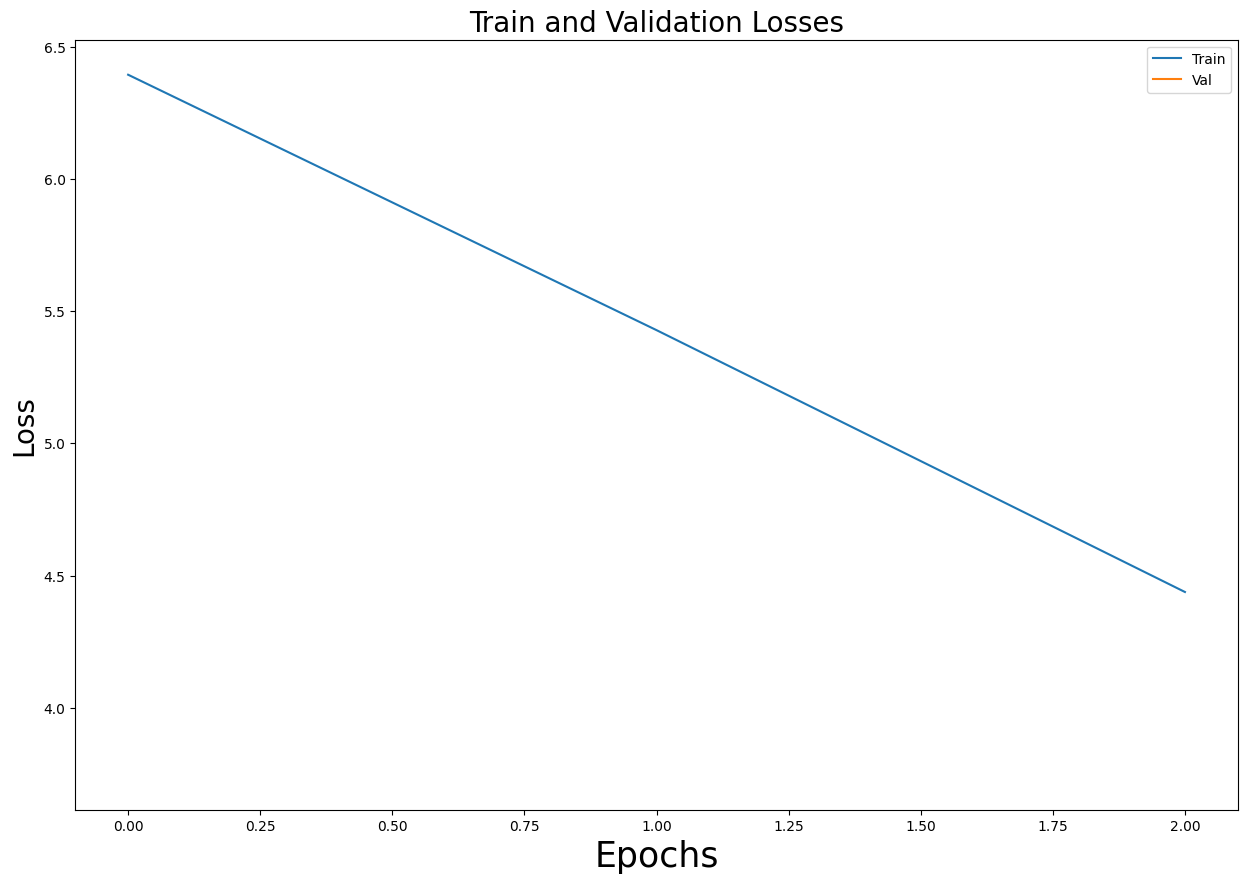

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

## ***Step 13:*** Load the fine tuned model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Define the bert tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Load the fine-tuned modeol
model = torch.load("/content/drive/MyDrive/finetunedmodelHopspot",map_location=torch.device('cpu'))

model.eval()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

## ***Step 14:*** Make the prediction and evaluate it